## Downloads and Update Package

In [1]:
!pip3 install --upgrade statsmodels
!pip3 install --upgrade tqdm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.9/9.9 MB 29.7 MB/s eta 0:00:00
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.12.2
    Uninstalling statsmodels-0.12.2:
      Successfully uninstalled statsmodels-0.12.2
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## Table of Content:

- Simple Time Series Analysis
- **Baseline** : AR, MA, ARIMA & SARIMA with no order tuning. 
- **Modeling with Unique CFIPS** : ARIMA & SARIMA models tuned with single order value for 3135 unique cfips based time series.

## Imports

In [2]:
from itertools import combinations
import warnings
import pickle

import pandas as pd
import numpy as np
from datetime import datetime
from tqdm import tqdm

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.arima.model import ARIMA as ARIMA
from statsmodels.tsa.seasonal import STL
import statsmodels.api as sm
import statsmodels.tsa.api as smt
from statsmodels.graphics.api import qqplot

from google.colab import drive
drive.mount('/content/drive')

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

Mounted at /content/drive


In [4]:
seed = 12
rs = np.random.RandomState(seed)
pd.options.display.float_format = '{:.2f}'.format
warnings.filterwarnings('ignore')

path_gdrive = '/content/drive/Shareddrives/DMP-W23/Repo/'

## Data

In [5]:
train = pd.read_csv(path_gdrive + 'data/train.csv')
test = pd.read_csv(path_gdrive + 'data/test.csv')

In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 122265 entries, 0 to 122264
Data columns (total 7 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   row_id                 122265 non-null  object 
 1   cfips                  122265 non-null  int64  
 2   county                 122265 non-null  object 
 3   state                  122265 non-null  object 
 4   first_day_of_month     122265 non-null  object 
 5   microbusiness_density  122265 non-null  float64
 6   active                 122265 non-null  int64  
dtypes: float64(1), int64(2), object(4)
memory usage: 6.5+ MB


## Simple Time Series Analysis

In [7]:
data = train[['first_day_of_month', 'microbusiness_density']].copy(deep = True)
# Convert to date
data['date'] = pd.to_datetime(data['first_day_of_month'])
data.drop(columns = 'first_day_of_month', inplace=True)
data.set_index('date', inplace=True)
data.head()

,microbusiness_density
date,
2019-08-01,3.01
2019-09-01,2.88
2019-10-01,3.06
2019-11-01,2.99
2019-12-01,2.99


- Creating a copy of the dataset consisting of the 2 features : **first_day_of_month** & **microbusiness_density**
- Converting the datatype of the **first_day_of_month** column to datetime datatype and setting it as the index of the dataset.
- Renaming the column **first_day_of_month** to **date**
- This time series has monthly frequency

In [8]:
data = data.groupby(data.index).mean() # Take the mean of each county for each month
data.head()

,microbusiness_density
date,
2019-08-01,3.75
2019-09-01,3.70
2019-10-01,3.78
2019-11-01,3.72
2019-12-01,3.72


- Originally the **train** dataset provided had data of **3135** unique **county - state** combination of **39 months**.
- We use **groupby** to compute the mean density for each month among all counties.
- Now, we only have 39 values for modeling with **2019-08-01** being the 1st value and **2022-10-01** being the last date value.

### Functions for Time Series Analysis

In statistics, an augmented Dickey–Fuller test (ADF) tests the null hypothesis that a unit root is present in a time series sample. A stationary time series is one whose properties do not depend on the time (month in our case) at which the series is observed. Thus, time series with trends, or with seasonality, are not stationary — the trend and seasonality will affect the value of the time series at different times. On the other hand, a white noise series is stationary — it does not matter when we observe it, it should look very much the same at any point in time. Some examples:

<center> 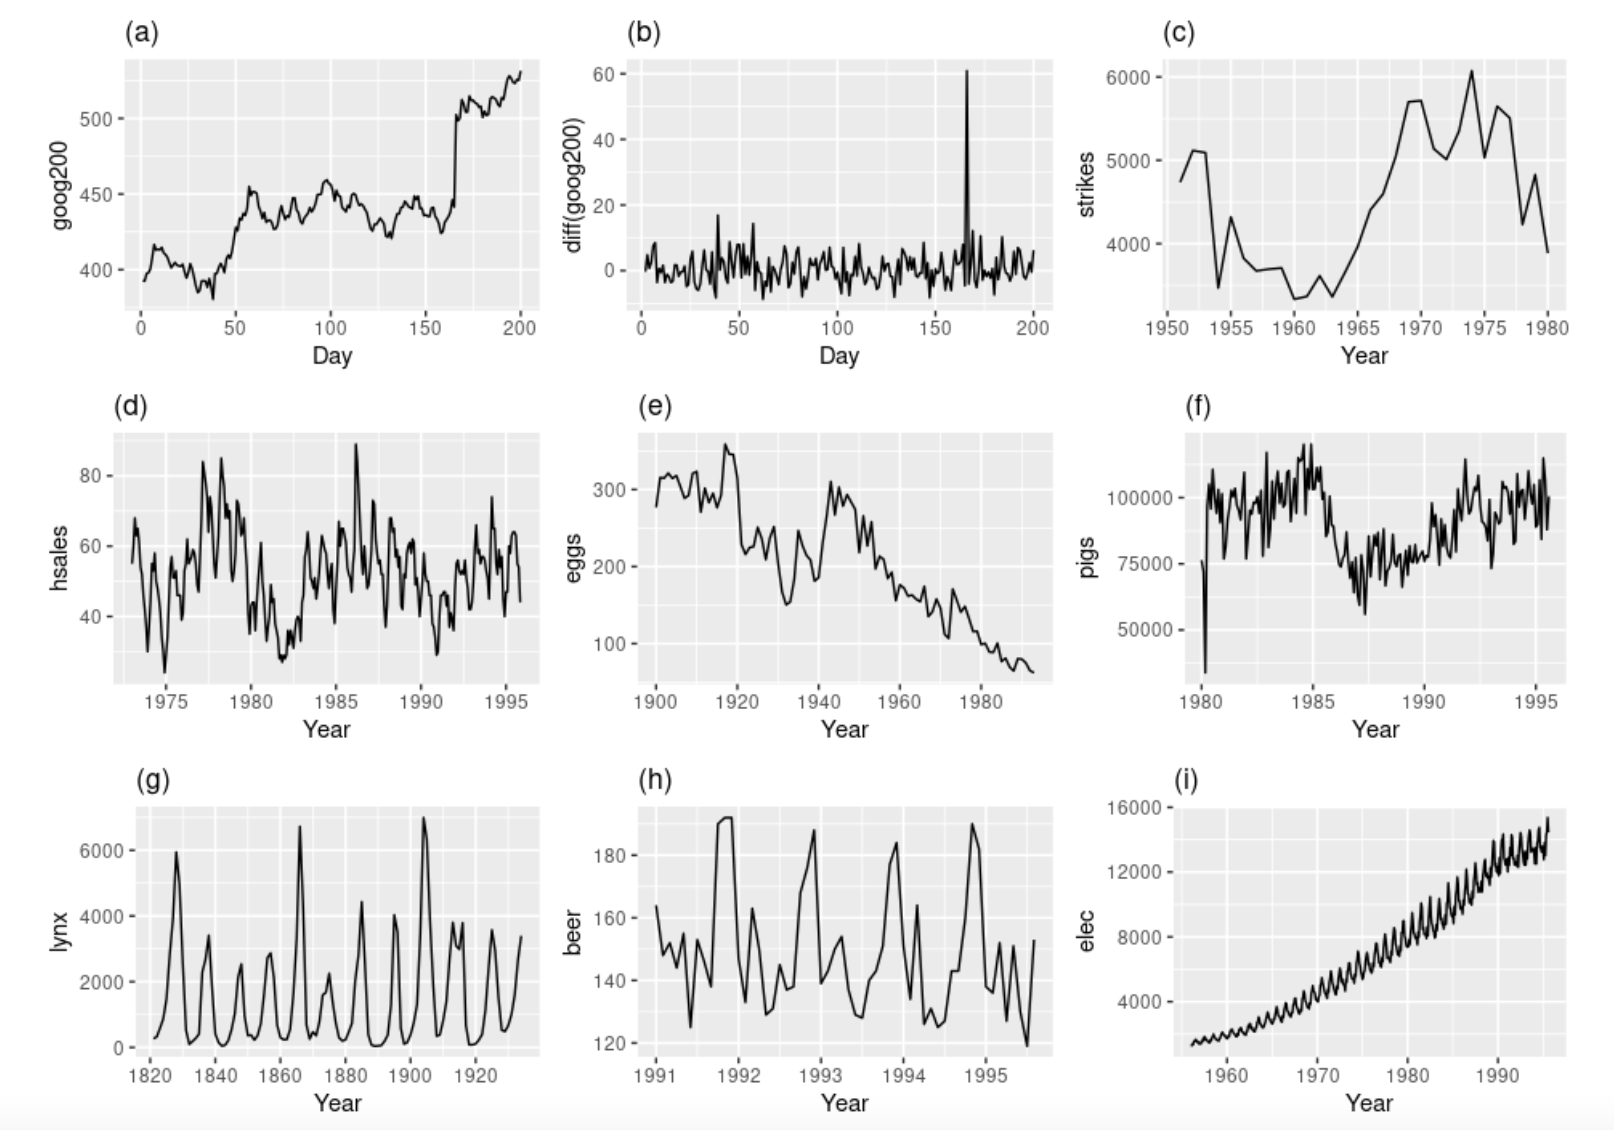 </center> 

Obvious seasonality rules out series (d), (h) and (i) as stationary series. Trends and changing levels rules out series (a), (c), (e), (f) and (i). Increasing variance also rules out (i). That leaves only (b) and (g) as stationary series.

The null hypothesis of the Augmented Dickey-Fuller test is that there is a unit root, with the alternative that there is no unit root. If the pvalue is above a critical size, then we cannot reject that there is a unit root. The intuition behind the test is:

* **Fail to reject ---> non-stationarity**: If the series is characterised by a unit root process, then the lagged level of the series $\left(y_{t-1}\right)$ will provide no relevant information in predicting the change in $y_t$ besides the one obtained in the lagged changes $\left(\Delta y_{t-k}\right)$. In this case, the null hypothesis of non-stationarity is not rejected. 

* **Reject ---> stationarity**: when the process has no unit root, it is stationary and hence exhibits reversion to the mean - so the lagged level will provide relevant information in predicting the change of the series and the null hypothesis of non-stationairity a unit root will be rejected.

In [9]:
def test_stationarity(timeseries: pd.DataFrame):
    """
    Test for stationarity of the sample data.
    """
    # Rolling statistics
    rolling_means = timeseries.rolling(window=12).mean() 
    rolling_stds = timeseries.rolling(window=12).std()

    # Plot rolling statistics
    plt.figure(figsize=(15,5))
    orig = plt.plot(timeseries, color='blue',label='Original Series')
    mean = plt.plot(rolling_means, color='red', label='Rolling Mean')
    std = plt.plot(rolling_stds, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)

    # Perform Dickey-Fuller test
    print('Results of Dickey-Fuller Test:')
    df_test = adfuller(x=timeseries, autolag='AIC') # Choose the number of lags from 0, 1, ..., maxlag, to minimize AIC
    df_output = pd.Series(df_test[0:4], index=['Test Statistic','p-value','# Lags Used','Number of Observations Used'])
    for key, value in df_test[4].items(): # Critical values are the fourth element 
        df_output['Critical Value (%s)'%key] = value
    print(df_output)

In [10]:
def tsplot(y: pd.Series, lags:int=None, figsize=(12, 10), style='ggplot'):
    """
    Plot the time series and conduct augmented Dickey-Fuller (p-value).
    """
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
        
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        layout = (2, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        
        y.plot(ax=ts_ax)
        p_value = sm.tsa.stattools.adfuller(y)[1]
        ts_ax.set_title(f'Time Series Analysis Plots\n Dickey-Fuller: p={p_value:.4f}')
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax) # Auto-correlation
        try:
            smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax) # Partial auto correlation
        except ValueError:
            pass
        plt.tight_layout()

In [11]:
def add_stl_plot(fig, res, legend):
    """
    Add 3 plots from a second STL fit.
    """
    axs = fig.get_axes()
    comps = ["trend", "seasonal", "resid"]
    for ax, comp in zip(axs[1:], comps):
        series = getattr(res, comp)
        if comp == "resid":
            ax.plot(series, marker="o", linestyle="none")
        else:
            ax.plot(series)
            if comp == "trend":
                ax.legend(legend, frameon=False)

### Components of Time Series

- A Time Series consists of the following components :

    - **Trend** : Long term direction of the data.
    
        - **E.g** : Year on year rising temperature of the Earth due to Global Warming.
    
    - **Seasonality** : Short term repetitve patterns of the data due to the weather seasons.
    
        - **E.g** : Sale of sweaters specifically in the winter season.
    
    - **Cyclic Variations** : Short term repetitive patterns of the data over a period of 1 year.
    
        - **E.g** : It usually consists of the Business Quarters i.e Q1, Q2, Q3 & Q4.
    
    - **Irregularities** : Random and unforseen fluctuations in the data.
    
        - **E.g** : Occurrences of Earthquakes or Floods, etc.

**In order to assess a Time Series, we need to consider the above components and make sure that our data is free from all these components in order to make a forecast.** We start by visualizing the `mircobusiness_density` data for the above components

- We use a function **seasonal_decompose** from the **statsmodel** library.
- This function has a parameter, **model**, that needs to be assigned the value **additive** or **multiplicative**.
    - **Additive Model** : Data has same width and height of the seasonal patterns or peaks. Trend of the data is linear.
    - **Multiplicative Model** : Data has increasing / decreasing width and height of the seasonal patterns or peaks. Trend of the data is non-linear.

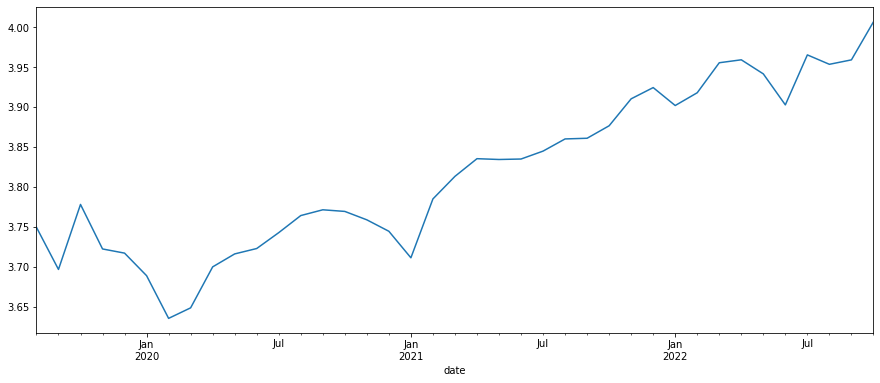

In [12]:
plt.figure(figsize = (15, 6))
data['microbusiness_density'].plot();

- It is unclear if there is **seasonality**. Micro-business density dips in values near the month of **January**. 
- There is a clear rising upward **trend** over time. We will first use the **ddditive model** value to divide the series for extracting more information.

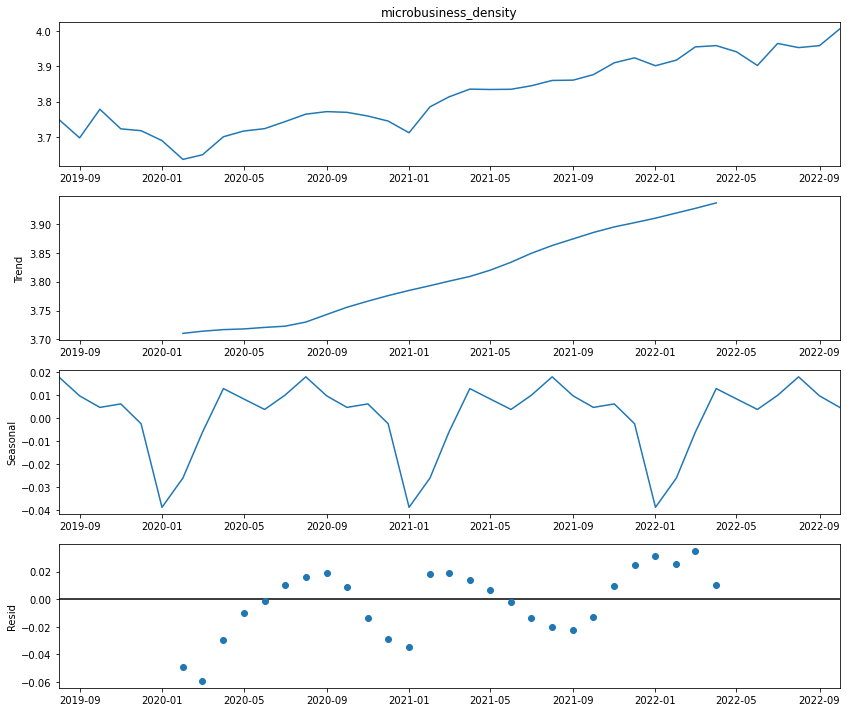

In [13]:
with mpl.rc_context():
    mpl.rc("figure", figsize=(12, 10))
    additive_decomposition = sm.tsa.seasonal_decompose(data['microbusiness_density'], period=12, model='additive').plot()
    plt.show()

- The data sample clearly has a **linear upward trend**.
- A **seasonal** pattern of a 1 year duration is present in the data. There are dips in density around **January** followed by troughs & crests in the months of **May - July**.

<center> 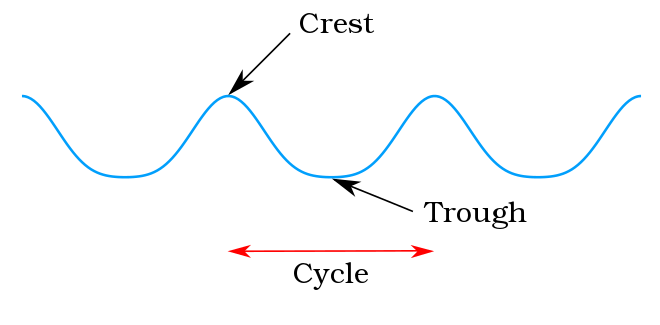 </center> 

In this approach, the series is decomposed naively using moving averages. We can also carry out seasonal-trend decomposition using LOESS, which uses locally fitted regression models to decompose a time series into trend, seasonal, and remainder components. We will set `robust` in the function below to True, which uses a data-dependent weighting function that re-weights data when estimating the LOESS. Using robust estimation allows the model to tolerate larger errors.

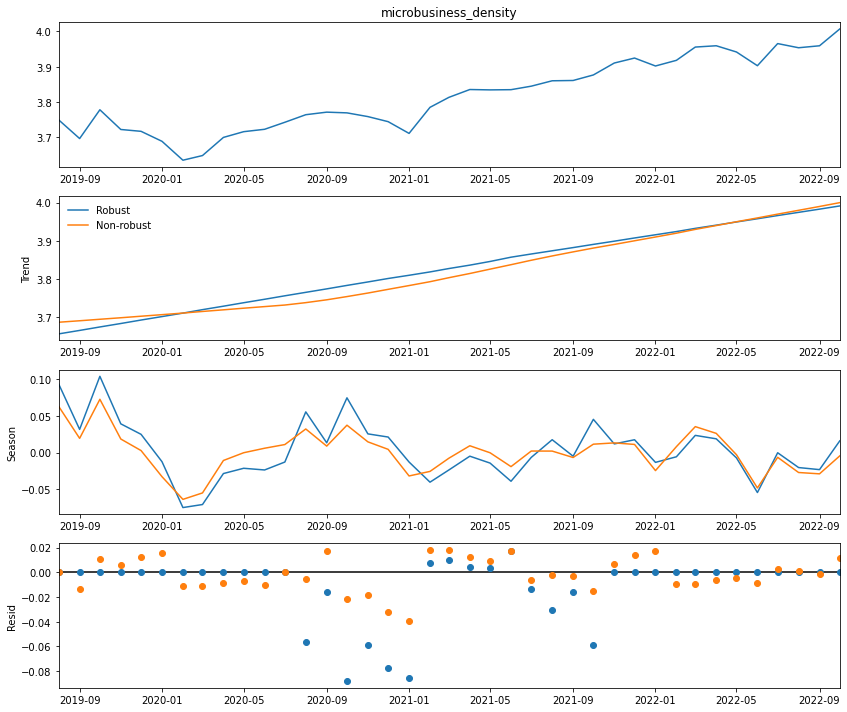

In [14]:
with mpl.rc_context():
    mpl.rc("figure", figsize=(12, 10))
    
    stl = STL(data['microbusiness_density'], period=12, robust=True)
    res_robust = stl.fit() # Robust
    fig = res_robust.plot()
    res_non_robust = STL(data['microbusiness_density'], period=12, robust=False).fit() # Non-robust
    add_stl_plot(fig, res_non_robust, ["Robust", "Non-robust"])

* Again, there appears to be a linear upward trend.

* However, the seasonality patterns of a 1 year duration is no longer pronouced. The dips in density around the month of January remains in 2020 and 2021 but became not as pronounced in 2022.

### Stationarity

- **Stationarity** is a concept for time series where statistical parameters like mean, variance, etc are more or less constant over time (in practice, it is unreasonable to expect perfect stationarity).
- For a time series, features are dependent on time i.e **features are a function of time**. Statistical paramters will change values over time as they are extracted from the features.
- If the time series is non-stationary, then prediction error will increase if we apply models with stationary assumptions to the sample.
- To test for stationarity, we will use **Augmented Dickey Fuller Test** : 
    - **Null Hypothesis** : It assumes that the time series is non-stationary.
    - **Alternate Hypothesis** : If the null hypothesis is rejected, the time series is stationary.
    - Output of the **Augmented Dickey Fuller Test** include :
        - **Test Statistic**
        - **p-value**
        - **# Lags Used**
        - **Number of Observations Used**
        - **Critical Value (1%)**
        - **Critical Value (5%)**
        - **Critical Value (10%)**
- For the **Null Hypothesis** to be rejected (i.e., the time series is stationary), there are 2 requirements :
    - **Critical Value (5%)** > **Test Statistic**
    - **p-value** < 0.05

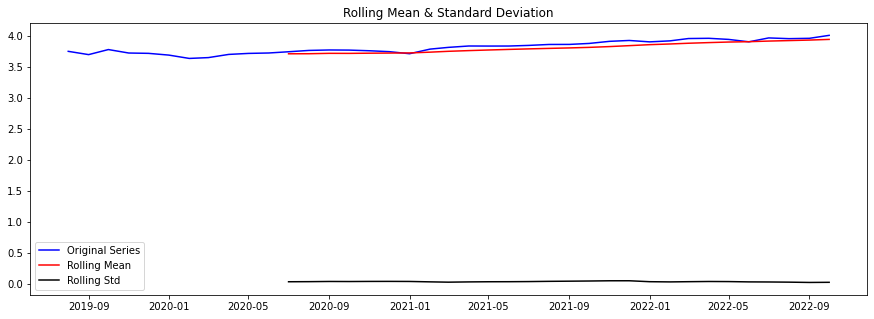

Results of Dickey-Fuller Test:
Test Statistic                -0.18
p-value                        0.94
# Lags Used                    0.00
Number of Observations Used   38.00
Critical Value (1%)           -3.62
Critical Value (5%)           -2.94
Critical Value (10%)          -2.61
dtype: float64


In [15]:
test_stationarity(data['microbusiness_density'])

- For the **microbusiness_density** time series data, 
    - **Rolling Mean** has a slight positive slope. 
    - **Rolling Standard Deviation** is virtially flat with zero slope.
    - **Test Statistic : (-0.18)** > **Critical Value (5%) : (-2.94)**
    - **p-value (0.94)** > 0.05
- Controlling type-I error at $\alpha=5\%$, we fail to reject the null hypothesis of **non-stationarity**.
- One way to make a non-stationary time series more stationary is to compute the differences between consecutive observations. This is known as **differencing**. Differencing can help stabilise the mean of a time series by removing changes in the level of a time series, and therefore eliminating (or reducing) trend and seasonality. The differenced series is the change between consecutive observations in the original series, and can be written as
$$
y_t^{\prime}=y_t-y_{t-1}
$$
The differenced series will have only $T-1$ values, since it is not possible to calculate a difference $y_1^{\prime}$ for the first observation.

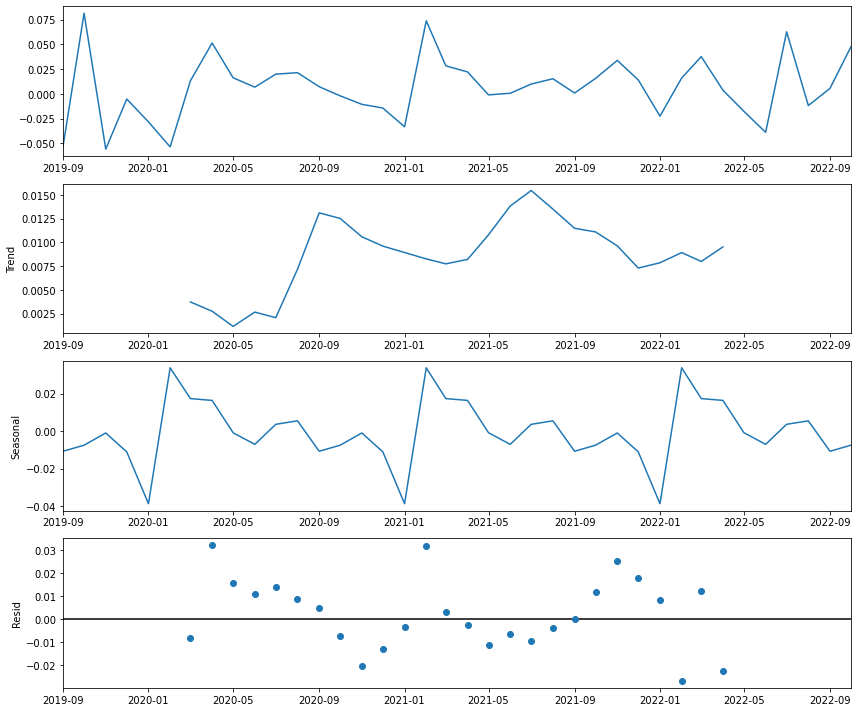

In [16]:
data_diff = data.diff(periods=1, axis=0)
data_diff.dropna(inplace=True) # Drop first observation since it is np.nan

with mpl.rc_context():
    mpl.rc("figure", figsize=(12, 10))
    additive_decomposition_diff = sm.tsa.seasonal_decompose(data_diff, period=12, model='additive').plot()
    plt.show()

- The **trend** of the data has been reduced. However, **seasonality** of the data is still present.

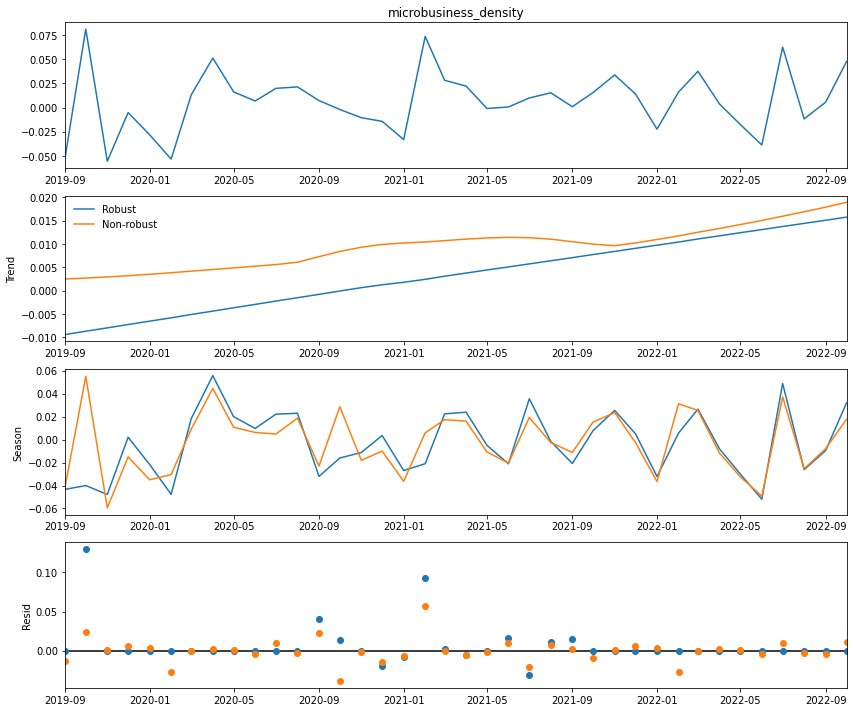

In [17]:
with mpl.rc_context():
    mpl.rc("figure", figsize=(12, 10))
    
    stl = STL(data_diff['microbusiness_density'], period=12, robust=True)
    res_robust = stl.fit() # Robust
    fig = res_robust.plot()
    res_non_robust = STL(data_diff['microbusiness_density'], period=12, robust=False).fit() # Non-robust
    add_stl_plot(fig, res_non_robust, ["Robust", "Non-robust"])

- The trend has indeed been reduced. The range of values is much smaller compared to the series without differencing.
- The residual is also stablized compared to the original series.

We now check for **stationarity** of the differenced time series.

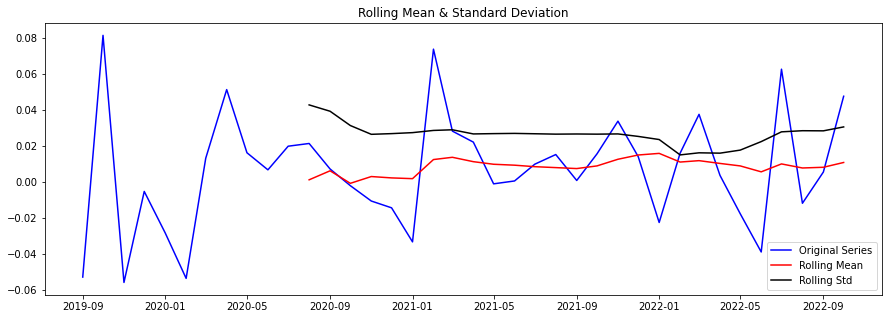

Results of Dickey-Fuller Test:
Test Statistic                -4.59
p-value                        0.00
# Lags Used                    1.00
Number of Observations Used   36.00
Critical Value (1%)           -3.63
Critical Value (5%)           -2.95
Critical Value (10%)          -2.61
dtype: float64


In [18]:
test_stationarity(data_diff)

- From the outputs of the **Augmented Dickey Fuller Test**,
    - **Rolling Mean** is very close to 0 and flat.
    - **Rolling Standard Deviation** is a positive but also fairly flat.
    - **Test Statistic : (-4.59)** < **Critical Value (5%) : (-2.95)**. 
    - **p-value (0.00)** < **0.05**
- Controlling type-I error rate at $\alpha=0.05$, we reject the null hypotehsis of non-stationarity.


For any times series analysis problem, **stationary** is very critical as the majority of statistical models have assumptions about stationarity.

## Baseline

- This is a naive approach where we create a simple time series analysis models without all the other features--- **cfips** & **county**.
- In this approach, we will use the following models :
    - **Auto Regression (AR)**
    - **Moving Average (MA)**
    - **Auto Regressive Integrated Moving Average (ARIMA)**
    - **Seasonal Auto Regressive Integrated Moving Average (SARIMA)**

### Auto Regression

In an **autoregression** model, we forecast the variable of interest using a linear combination of past values of the variable. The term autoregression indicates that it is a regression of the variable against itself. An autoregressive model of order $p$ can be written as
    $$
    y_t=c+\phi_1 y_{t-1}+\phi_2 y_{t-2}+\cdots+\phi_p y_{t-p}+\varepsilon_t
    $$
where $\varepsilon_t$ is white noise (time series that show no autocorrelation are called white noise). This is like a multiple regression but with lagged values of $y_t$ as predictors. We refer to this as an $\operatorname{AR}(p)$ model, an autoregressive model of order $p$. We normally restrict autoregressive models to stationary data, in which case some constraints on the values of the parameters are required.

   - For an AR(1) model: $-1<\phi_1<1$.
   - For an AR(2) model: $-1<\phi_2<1, \phi_1+\phi_2<1, \phi_2-\phi_1<1$.
    
When $p \geq 3$, the restrictions are much more complicated, but most softwares will handle this without further specifications.
    
This relationship between observations is known as correlation. There are 2 types of correlation :

   - **Positive Correlation : Both values of the observations move in the same direction**
   - **Negative Correlation : Both values of the observations move in the opposite direction**

The stronger the correlation between the output variable and a specific lagged variable, the more weight that autoregression model can place on that variable when modeling.

* Original time series:

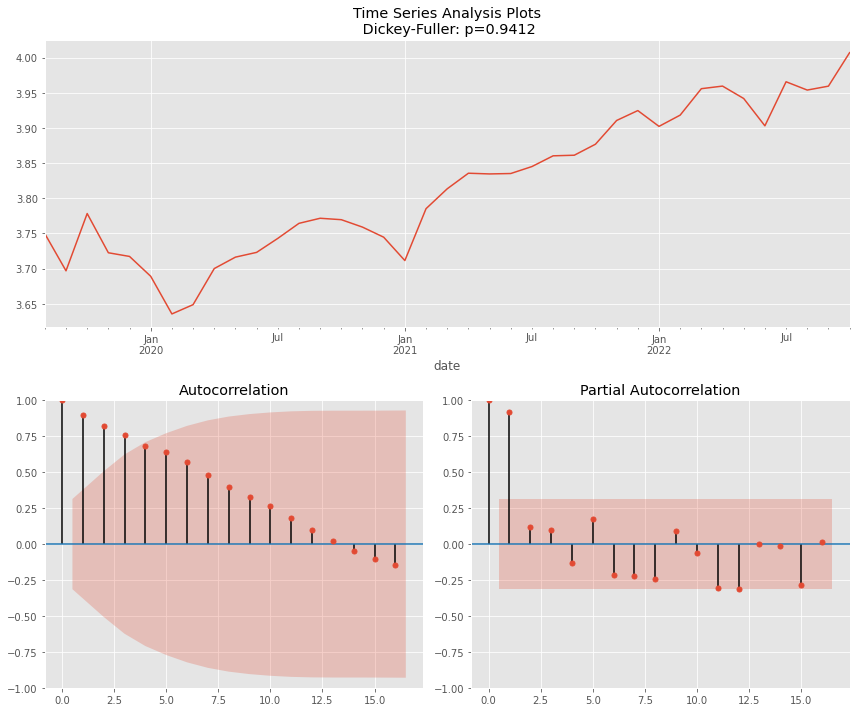

In [19]:
tsplot(data['microbusiness_density'])

* Differenced time series:

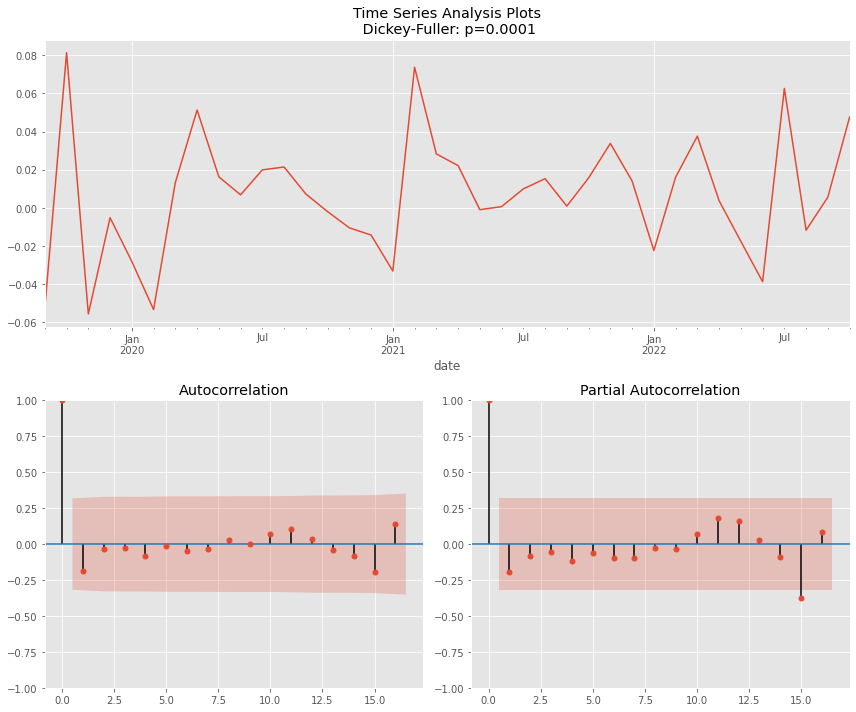

In [20]:
tsplot(data_diff['microbusiness_density'])

- In the above plots of correlations:
    - The x-axis is the number of lagged periods $k$
    - The y-axis is the autocorrelation coefficient between between -1 and 1 with a confidence interval. The value of $r_k$ can be written as
        $$
        r_k=\frac{\sum_{t=k+1}^T\left(y_t-\bar{y}\right)\left(y_{t-k}-\bar{y}\right)}{\sum_{t=1}^T\left(y_t-\bar{y}\right)^2},
        $$
        where $T$ is the length of the time series.
- The autocorrelation measures the linear relationship between lagged values of a time series. The autocorrelation function helps assess the properties of a time series. 

    - When data have a **trend**, the autocorrelations for small lags tend to be large and positive because observations nearby in time are also nearby in size. So the ACF of trended time series tend to have positive values that slowly decrease as the lags increase.

    - When data are **seasonal**, the autocorrelations will be larger for the seasonal lags (at multiples of the seasonal frequency) than for other lags.

  In contrast, the partial autocorrelation function (PACF) is more useful during the specification process for an autoregressive model.

- For a white noise series, we expect 95% of the spikes in the ACF to lie within $\pm 2 / \sqrt{T}$ where $T$ is the length of the time series. It is common to plot these bounds on a graph of the ACF or PACF. If one or more large spikes are outside these bounds, or if substantially more than $5\%$ of spikes are outside these bounds, then the series is probably not white noise.
  
- From the partial auto-correlation plot of the differenced series, the no lags appear to be statistically significant (i.e., spikes beyond the bounds) and hence we will use **AR (p) : 0** (constant only).

For modeling AR, we will use the **ARIMA** model initialization where we set the `order` parameter to **(0, 0, 0)**. The `(p,d,q)` argument specifies the order of the model for the 'autoregressive', 'differences', and 'moving average components'--- `d` is always an integer, while `p` and `q` may either be integers or lists of integers. We set orders of `d` & `q`  to 0 since we only want to make use of the **AR (p)** model.

In [21]:
ar_model = ARIMA(data_diff['microbusiness_density'],order = (0, 0, 0))
ar_model_fit = ar_model.fit()
print(ar_model_fit.summary())

                                 SARIMAX Results                                 
Dep. Variable:     microbusiness_density   No. Observations:                   38
Model:                             ARIMA   Log Likelihood                  76.872
Date:                   Wed, 22 Feb 2023   AIC                           -149.744
Time:                           10:24:52   BIC                           -146.469
Sample:                       09-01-2019   HQIC                          -148.579
                            - 10-01-2022                                         
Covariance Type:                     opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0068      0.005      1.296      0.195      -0.003       0.017
sigma2         0.0010      0.000      4.357      0.000       0.001       0.001
Ljung-Box (L1) (Q):         

#### Serial Correlation of Residuals

1. The null hypothesis of the Durbin-Watson test is that there is no serial correlation in the residuals. The Durbin-Watson test statistic is defined as:
    $$
    \sum_{t=2}^T\left(\left(e_t-e_{t-1}\right)^2\right) / \sum_{t=1}^T e_t^2
    $$
    The test statistic is approximately equal to $2 \times (1-r)$ where $r$ is the sample autocorrelation of the residuals. Thus, for $r=0$, indicating no serial   correlation, the test statistic equals 2. This statistic will always be between 0 and 4. The closer to 0 the statistic, the more evidence for positive serial correlation. The closer to 4, the more evidence for negative serial correlation.

In [22]:
sm.stats.durbin_watson(ar_model_fit.resid.values)

2.241806794206118

As a rule of thumb, values between 1.5 to 2.5 are acceptable deviations from 2 (no serial correlation in the residuals). 

2. The Ljung-Box test is a statistical test that checks if autocorrelation exists in the residuals; it tests the null hypothesis that the residuals are independently distributed against the alternative that the residuals are not independently distributed. 

In [23]:
sm.stats.diagnostic.acorr_ljungbox(ar_model_fit.resid, lags=None)

,lb_stat,lb_pvalue
1,1.45,0.23
2,1.51,0.47
3,1.54,0.67
4,1.85,0.76
5,1.85,0.87
6,1.97,0.92
7,2.03,0.96


Controlling type-1 error rate at any rate, we fail to reject the null hypothesis of no serial correlation for all lags 1 - 7.

#### Normality of Residuals

In [24]:
sm.stats.diagnostic.kstest_normal(ar_model_fit.resid, dist='norm')

(0.10719907302630349, 0.3374670878069955)

Controlling type-1 error rate at any rate, we fail to reject the null hypothesis that the residuals are normally distributed.

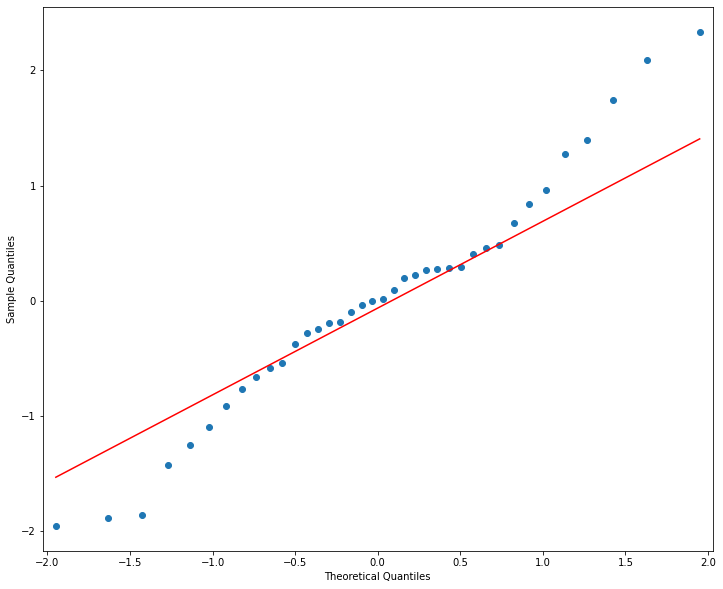

In [25]:
with mpl.rc_context():
    mpl.rc("figure", figsize=(12, 10))
    qqplot(ar_model_fit.resid, line='q', fit=True)

### Moving Average Model

Rather than using past values of the forecast variable in a regression, a **moving average model** uses past forecast errors in a regression-like model.

$$
y_t=c+\varepsilon_t+\theta_1 \varepsilon_{t-1}+\theta_2 \varepsilon_{t-2}+\cdots+\theta_q \varepsilon_{t-q},
$$

where 

* $\varepsilon_t$ is white noise. 

We refer to this as an $\operatorname{MA}(q)$ model, a moving average model of order $q$. We do not observe the values of $\varepsilon_t$, so it is not really a regression in the usual sense. In the autocorrelation plot above, the first order lags appear to be significant; therefore, we will use **MA (q) : 1**.

In [26]:
ma_model = ARIMA(data_diff['microbusiness_density'],order = (0, 0, 1))
ma_model_fit = ma_model.fit()
print(ma_model_fit.summary())

                                 SARIMAX Results                                 
Dep. Variable:     microbusiness_density   No. Observations:                   38
Model:                    ARIMA(0, 0, 1)   Log Likelihood                  77.744
Date:                   Wed, 22 Feb 2023   AIC                           -149.488
Time:                           10:25:09   BIC                           -144.575
Sample:                       09-01-2019   HQIC                          -147.740
                            - 10-01-2022                                         
Covariance Type:                     opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0068      0.005      1.429      0.153      -0.003       0.016
ma.L1         -0.2404      0.158     -1.526      0.127      -0.549       0.068
sigma2         0.0010      0

#### Serial Correlation Assumption

In [27]:
sm.stats.durbin_watson(ma_model_fit.resid.values)

1.8235770817944965

In [28]:
sm.stats.diagnostic.acorr_ljungbox(ma_model_fit.resid, lags=None)

,lb_stat,lb_pvalue
1,0.02,0.90
2,0.11,0.95
3,0.26,0.97
4,0.90,0.93
5,0.97,0.97
6,1.13,0.98
7,1.21,0.99


#### Normality Assumption

In [29]:
sm.stats.diagnostic.kstest_normal(ma_model_fit.resid, dist='norm')

(0.08732819360359545, 0.6548727389815132)

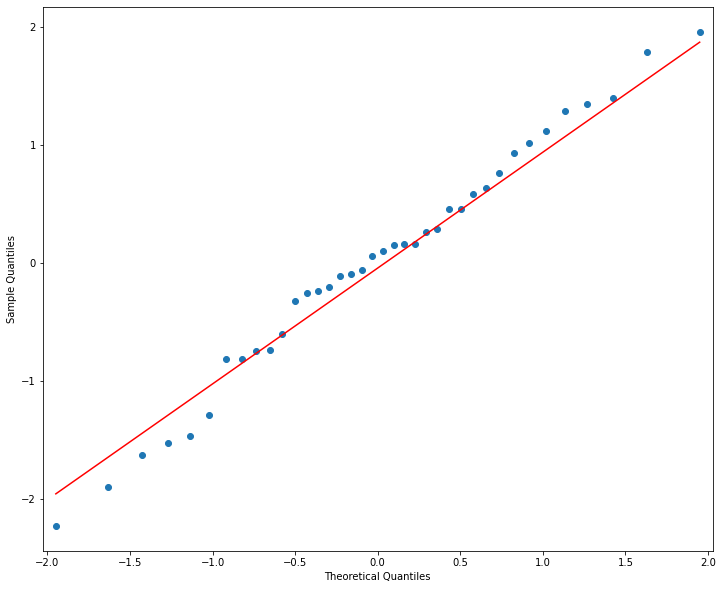

In [30]:
with mpl.rc_context():
    mpl.rc("figure", figsize=(12, 10))
    qqplot(ma_model_fit.resid, line='q', fit=True)

### Auto Regressive Integrated Moving Average (ARIMA)

If we combine differencing with autoregression and a moving average model, we obtain a nonseasonal ARIMA model. ARIMA is an acronym for AutoRegressive Integrated Moving Average (in this context, "integration" is the reverse of differencing). The full model can be written as

$$
y_t^{\prime}=c+\phi_1 y_{t-1}^{\prime}+\cdots+\phi_p y_{t-p}^{\prime}+\theta_1 \varepsilon_{t-1}+\cdots+\theta_q \varepsilon_{t-q}+\varepsilon_t,
$$

where $y_t^{\prime}$ is the differenced series (it may have been differenced more than once). The "predictors" on the right hand side include both lagged values of $y_t$ and lagged errors. We call this an $\operatorname{ARIMA}(p, d, q)$ model, where

* $p=$ order of the autoregressive part;
* $d=$ degree of first differencing involved;
* $q=$ order of the moving average part.

The Selection criteria for the order of **ARIMA** model: 

* **p** : Lag value where the **Partial Autocorrelation (PACF)** graph cuts off or drops to 0 for the 1st instance.
* **d** : Number of times differencing is carried out to make the time series stationary.
* **q** : Lag value where the **Autocorrelation (ACF)** graph crosses the upper confidence interval for the 1st instance.

We will use the following order of **ARIMA** model is selected:

* **p** : 0 (no significant lags in the partial autocorrelation plot)
* **d** : 1 (to make the original series stationary)
* **q** : 0 (no significant first-order lags in the autocorrelation plot of the differenced series)

Note that we use the original time series before differencing and allow the implementation to carry out the differencing before modeling.

In [31]:
arima_model = ARIMA(data['microbusiness_density'], order=(0, 1, 0))
arima_model_fit = arima_model.fit()
print(arima_model_fit.summary())

                                 SARIMAX Results                                 
Dep. Variable:     microbusiness_density   No. Observations:                   39
Model:                    ARIMA(0, 1, 0)   Log Likelihood                  76.040
Date:                   Wed, 22 Feb 2023   AIC                           -150.080
Time:                           10:25:23   BIC                           -148.442
Sample:                       08-01-2019   HQIC                          -149.497
                            - 10-01-2022                                         
Covariance Type:                     opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         0.0011      0.000      4.494      0.000       0.001       0.002
Ljung-Box (L1) (Q):                   1.45   Jarque-Bera (JB):                 0.13
Prob(Q):               

#### Serial Correlation Assumption

In [32]:
sm.stats.durbin_watson(arima_model_fit.resid.values)

1.0315704788244344

In [33]:
sm.stats.diagnostic.acorr_ljungbox(arima_model_fit.resid, lags=None)

,lb_stat,lb_pvalue
1,0.01,0.91
2,0.03,0.99
3,0.04,1.00
4,0.05,1.00
5,0.05,1.00
6,0.08,1.00
7,0.08,1.00


#### Normality Assumption

In [34]:
sm.stats.diagnostic.kstest_normal(arima_model_fit.resid, dist='norm')

(0.48853052542832703, 0.0009999999999998899)

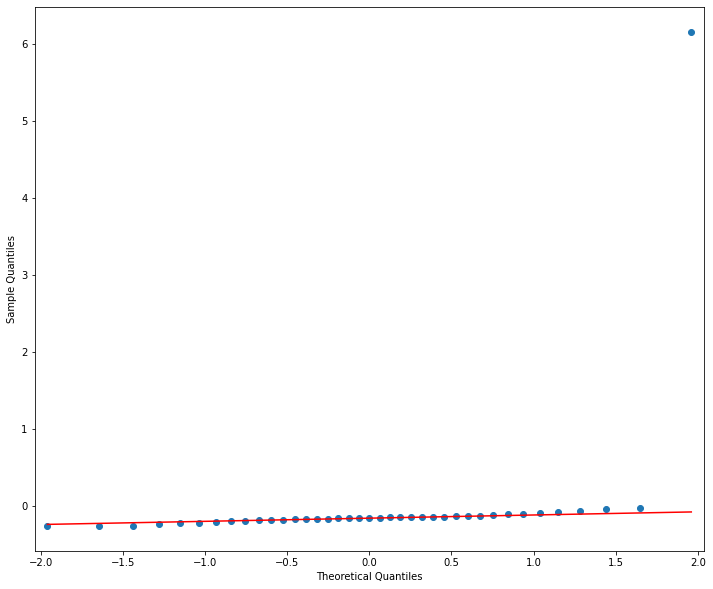

In [35]:
with mpl.rc_context():
    mpl.rc("figure", figsize=(12, 10))
    qqplot(arima_model_fit.resid, line='q', fit=True)

The normality assumption is violated. While the model can still be used for forcasting, but inferences such as hypothesis testing and confidence intervals are based on the normal error assumption.

### Seasonal Auto Regressive Integrated Moving Average

A seasonal ARIMA model is formed by including additional seasonal terms in the ARIMA models we have seen so far. It is written as follows:
$$
\text { ARIMA } \quad \underbrace{(p, d, q)}_{\text{Non-seasonal part of the model}} \quad \underbrace{(P, D, Q)_m}_{\text{Seasonal part of the model}}
$$
where $m=$ number of observations per year. We use uppercase notation for the seasonal parts of the model, and lowercase notation for the non-seasonal parts of the model. First, we take a seasonal difference (12 months).

In [36]:
data_diff_seas = data.diff(periods=12)
data_diff_seas.dropna(inplace=True)

Next, we decompose the seasonally differenced series into trend, seasonality, and residuals. 

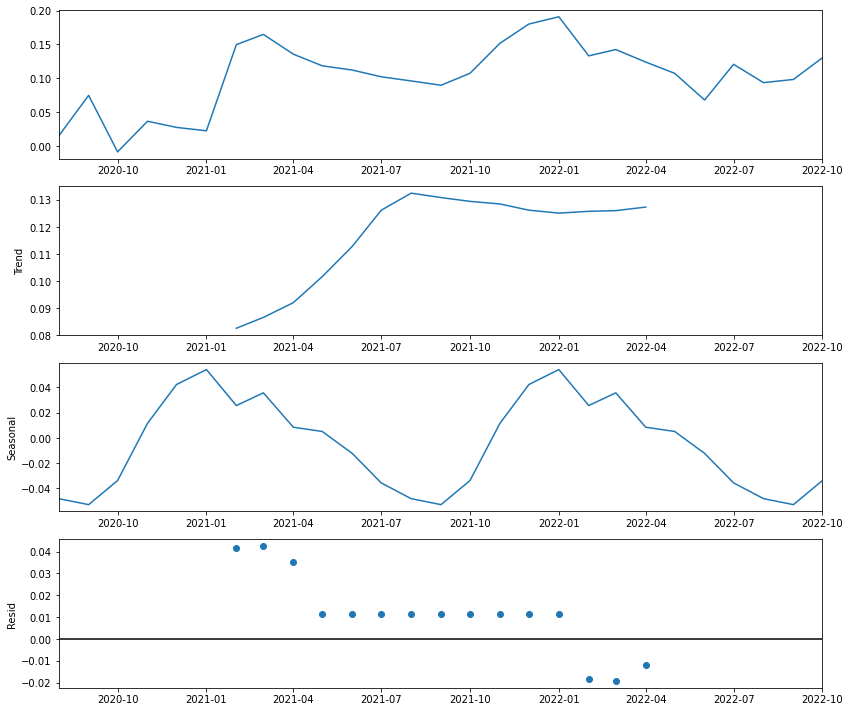

In [37]:
with mpl.rc_context():
    mpl.rc("figure", figsize=(12, 10))
    additive_decomposition_diff = sm.tsa.seasonal_decompose(data_diff_seas, period=12, model='additive').plot()
    plt.show()

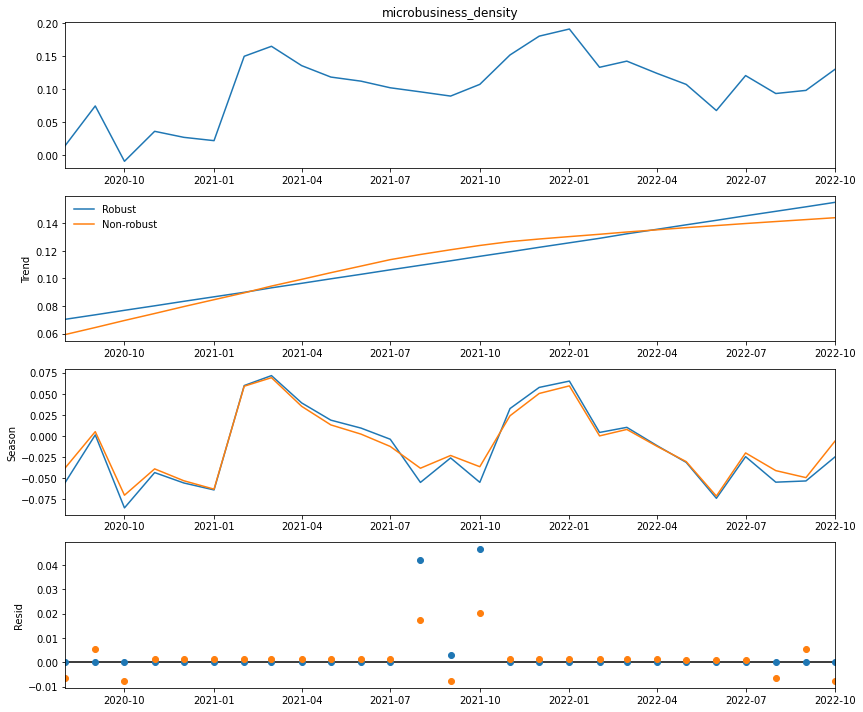

In [38]:
with mpl.rc_context():
    mpl.rc("figure", figsize=(12, 10))
    
    stl = STL(data_diff_seas['microbusiness_density'], period=12, robust=True)
    res_robust = stl.fit() # Robust
    fig = res_robust.plot()
    res_non_robust = STL(data_diff_seas['microbusiness_density'], period=12, robust=False).fit() # Non-robust
    add_stl_plot(fig, res_non_robust, ["Robust", "Non-robust"])

There is defintely still a seasonality pattern. We need to test for stationarity below.

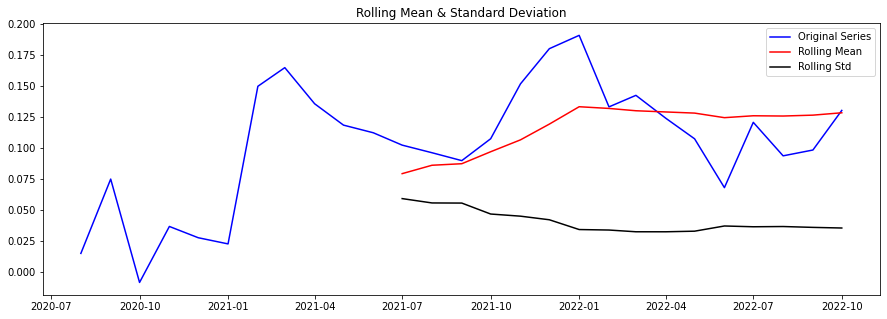

Results of Dickey-Fuller Test:
Test Statistic                -2.64
p-value                        0.09
# Lags Used                    0.00
Number of Observations Used   26.00
Critical Value (1%)           -3.71
Critical Value (5%)           -2.98
Critical Value (10%)          -2.63
dtype: float64


In [39]:
test_stationarity(data_diff_seas['microbusiness_density'])

Only when controlling type-I error rate at $\alpha=0.1$ do we reject the null hypothesis of non-stationarity. The evidence is not strong enough for us to reject the null hypothesis in favor of the alternative--- stationarity.

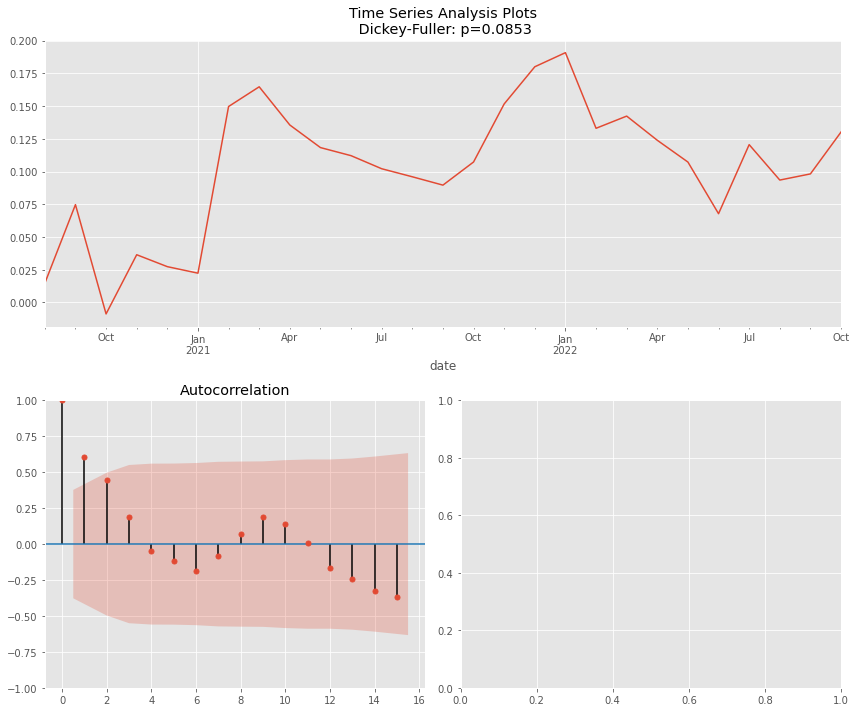

In [40]:
tsplot(data_diff_seas['microbusiness_density'])

For the **SARIMA** model, order of **(p,d,q)** will be same as the order of the **ARIMA** model above. For **(P,D,Q,M)**:
- **P** : 0
- **D** : 1
- **Q** : 1 (the first lagged value in the ACF appears to be statistically significant)
- **M** : 12

In [41]:
sarima_model = sm.tsa.statespace.SARIMAX(data_diff_seas['microbusiness_density'], order=(0,1,1), seasonal_order=(0,1,1,12))
sarima_model_fit = sarima_model.fit()
print(sarima_model_fit.summary())

                                     SARIMAX Results                                      
Dep. Variable:              microbusiness_density   No. Observations:                   27
Model:             SARIMAX(0, 1, 1)x(0, 1, 1, 12)   Log Likelihood                  19.132
Date:                            Wed, 22 Feb 2023   AIC                            -32.264
Time:                                    10:25:46   BIC                            -30.346
Sample:                                08-01-2020   HQIC                           -32.441
                                     - 10-01-2022                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.2700      0.378     -0.714      0.475      -1.011       0.471
ma.S.L12       0.1886      3.615   

#### Serial Correlation Assumption

In [42]:
sm.stats.durbin_watson(sarima_model_fit.resid.values)

2.1121614802022024

In [43]:
sm.stats.diagnostic.acorr_ljungbox(sarima_model_fit.resid, lags=None)

,lb_stat,lb_pvalue
1,0.10,0.75
2,0.34,0.84
3,0.36,0.95
4,3.56,0.47
5,3.56,0.61


#### Normality Assumption

In [44]:
sm.stats.diagnostic.kstest_normal(sarima_model_fit.resid, dist='norm')

(0.15919532896541982, 0.07637708332796564)

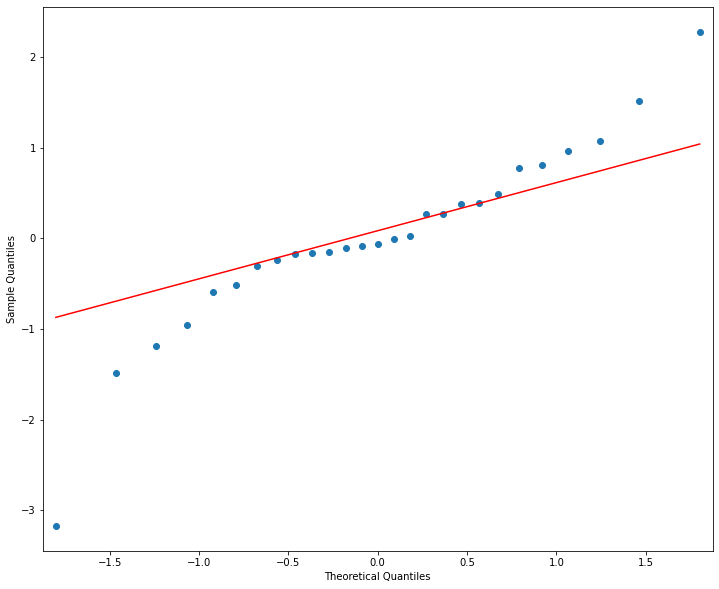

In [45]:
with mpl.rc_context():
    mpl.rc("figure", figsize=(12, 10))
    qqplot(sarima_model_fit.resid, line='q', fit=True)

### Model Comparison

We compare the AIC and BIC of the four models to determine the model to use for forecasting:

In [46]:
pd.DataFrame({
    'model': ['AR', 'MA', 'ARIMA', 'SARIMA'],
    'aic': [ar_model_fit.aic, ma_model_fit.aic, arima_model_fit.aic, sarima_model_fit.aic],
    'bic': [ar_model_fit.bic, ma_model_fit.bic, arima_model_fit.bic, sarima_model_fit.bic]
})

,model,aic,bic
0,AR,-149.74,-146.47
1,MA,-149.49,-144.57
2,ARIMA,-150.08,-148.44
3,SARIMA,-32.26,-30.35


Because the ARIMA model has the lowest AIC and BIC, we will use it for forecasting. 

### Out of Sample Forecasting:

- We create a new dataframe that is the copy of the test dataset. 
- For this **Out - of - Sample Forecasting**, we use the **rolling** method. In the **rolling** method, we forecast or predict the next single value (next month's forecasted density), and then use this predicted value again for model fitting. This new model is then used for predicting the next value, and so on.

In [47]:
test['first_day_of_month'] = pd.to_datetime(test['first_day_of_month'])
baseline_test = test.copy(deep = True)
baseline_test.set_index('first_day_of_month', inplace=True)
baseline_test = baseline_test.groupby(baseline_test.index).mean()
baseline_test

,cfips
first_day_of_month,
2022-11-01,30376.04
2022-12-01,30376.04
2023-01-01,30376.04
2023-02-01,30376.04
2023-03-01,30376.04
2023-04-01,30376.04
2023-05-01,30376.04
2023-06-01,30376.04


- In the **test** data, after using **groupby**, we only have 8 values from **2022-11-01** to **2023-06-01**.
- However, the test data has 25080 observations. In order to match this, we create a copy of the test dataset, convert the **first_day_of_month** feature to datetime & assign it as the index of this copied dataframe.
- We now use the **rolling forecast** to predict the next 8 values.

#### Rolling Forecasting

In [48]:
train_sample = data['microbusiness_density'].tolist()
forecast = []

for t in tqdm(range(len(baseline_test))):

    model = ARIMA(train_sample, order = (0,1,0)) # As we iterate, the training sample becomes larger since we include each of the forecasted densities
    model_fit = model.fit() # Refit model on new training set
    
    output = model_fit.forecast(steps=1)[0] # The first element returned is the array of out of sample forecasts
    
    train_sample.append(output) # At the end of each iteration, add the forecasted next month density to the training set
    forecast.append(output) # Add the forecasted next month density to the forecasted results container

baseline_test['forecast'] = 0
for i in range(len(forecast)):
    baseline_test.iloc[i, 1] = forecast[i]

baseline_test

100%|██████████| 8/8 [00:00<00:00, 38.83it/s]


,cfips,forecast
first_day_of_month,,
2022-11-01,30376.04,4.01
2022-12-01,30376.04,4.01
2023-01-01,30376.04,4.01
2023-02-01,30376.04,4.01
2023-03-01,30376.04,4.01
2023-04-01,30376.04,4.01
2023-05-01,30376.04,4.01
2023-06-01,30376.04,4.01


As can be seen, the simple baseline ARIMA model with no lagged feature, first order differencing, and no moving average component simply forecasts the same value for the next 8 months.

### Model Evaluation

To evaluate the model, we first plot the next 8 months with the training data:

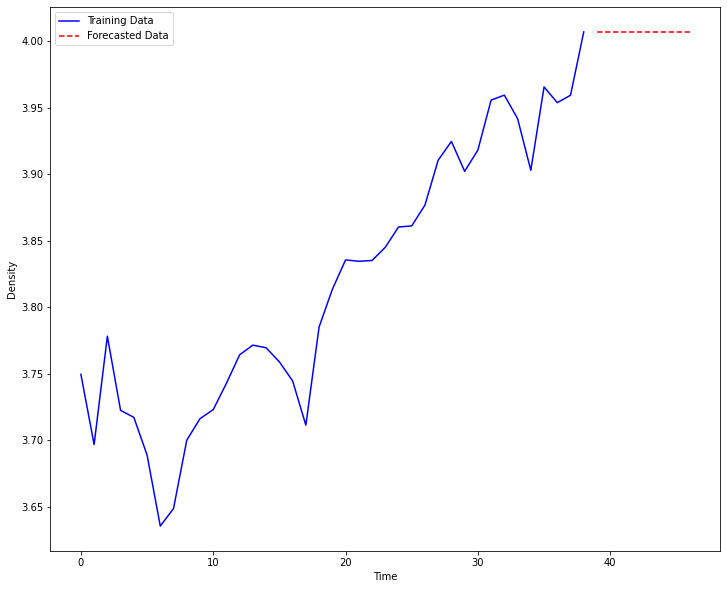

In [51]:
# Indices for time series
train_index = np.arange(len(data['microbusiness_density']))
forecast_index = np.arange(len(data['microbusiness_density']), len(data['microbusiness_density']) + len(baseline_test))

fig, ax = plt.subplots(figsize=(12, 10))

# Plot the training data with a solid blue line
ax.plot(train_index, data['microbusiness_density'], color='blue', linestyle='solid', label='Training Data')

# Plot the forecasted data with a dashed red line
ax.plot(forecast_index, baseline_test['forecast'], color='red', linestyle='dashed', label='Forecasted Data')

# Set the axis labels and legend
ax.set_xlabel('Time')
ax.set_ylabel('Density')
ax.legend()

# Show the plot
plt.show();

Next, we map the predicted values to the test set:

In [52]:
baseline_forecast = test.copy(deep=True)
baseline_forecast.set_index('first_day_of_month', inplace=True)
baseline_forecast['microbusiness_density'] = baseline_test['forecast'] # The 8 month forecasted values will be mapped to the corresponding first_day_of_month indices

baseline_forecast

,row_id,cfips,microbusiness_density
first_day_of_month,,,
2022-11-01,1001_2022-11-01,1001,4.01
2022-11-01,1003_2022-11-01,1003,4.01
2022-11-01,1005_2022-11-01,1005,4.01
2022-11-01,1007_2022-11-01,1007,4.01
2022-11-01,1009_2022-11-01,1009,4.01
...,...,...,...
2023-06-01,56037_2023-06-01,56037,4.01
2023-06-01,56039_2023-06-01,56039,4.01
2023-06-01,56041_2023-06-01,56041,4.01


In [54]:
# Write forecast to disk
baseline_forecast[['row_id', 'microbusiness_density']].to_csv(path_gdrive + 'output/baseline_forecast.csv', index=False)

#### Evaluation Metric

The performance of our model will be evaluated on SMAPE between the forecasted values and the actual values. The symmetric mean absolute percentage error is an accuracy measure based on percentage (or relative) errors. It is usually defined as follows:

$$
\text { SMAPE }=\frac{100 \%}{n} \sum_{t=1}^n \frac{\left|F_t-A_t\right|}{\left(\left|A_t\right|+\left|F_t\right|\right) / 2}
$$

where $A_t$ is the actual value and $F_t$ is the forecasted value.

The absolute difference between $A_t$ and $F_t$ is divided by half the sum of absolute values of the actual value $A_t$ and the forecast value $F_t$. The value of this calculation is summed for every fitted point $t$ and divided again by the number of fitted points $n$.

**The baseline model performs rather poorly on the actual values. Based on the on-going Kaggle competition, our baseline model results in a SMAPE of 61.0.259 on the test set, which places us in the 2775th place out of 2840 teams.** 

## Modeling using Unique CFIPS

In this approach, we will create time series models that use the feature of `cfips` for forecasting. For each unique value of `cfips` (i.e., a single combination of state and county), we create a unique model to forecast the values for that specific value of `cfips`. Based on the baseline results, we will use the non-seasonal ARIMA model.

In [57]:
cfips_model_train = train[['first_day_of_month', 'microbusiness_density','cfips']].copy(deep = True)
cfips_model_train['date'] = pd.to_datetime(cfips_model_train['first_day_of_month']) # Convert to date
cfips_model_train.drop(columns = 'first_day_of_month', inplace=True)

cfips_model_train = cfips_model_train.groupby(['cfips','date']).mean()
cfips_model_train.head(10)

microbusiness_density
cfips date                             
1001  2019-08-01                   3.01
      2019-09-01                   2.88
      2019-10-01                   3.06
      2019-11-01                   2.99
      2019-12-01                   2.99
      2020-01-01                   2.97
      2020-02-01                   2.91
      2020-03-01                   2.93
      2020-04-01                   3.00
      2020-05-01                   3.00

In [58]:
len(np.unique(cfips_model_train.index.get_level_values('cfips'))) # Unique cfpis

3135

- We create a copy of the **training set** consisting of the 3 features : **first_day_of_month**, **microbusiness_density** & **cfips**.
- We convert the datatype of the **first_day_of_month** column to datetime datatype and set it as the index.
- We **groupby** two features **cfips** & **date**.

We now have 3135 unique **cfips** values each consisting of 39 **date** values for **microbusiness_density**. Our goal is to create models for each of the 3135 unique **cfips** values. 

### ARIMA

For ARIMA, we will use the same model specifications with no lagged features, first order differencing, and no moving average components.

In [59]:
cfips_model_test = test.copy(deep = True)
cfips_model_test['date'] = pd.to_datetime(cfips_model_test['first_day_of_month'])

cfips_model_test.drop(columns = 'first_day_of_month', inplace=True)

cfips_model_test = cfips_model_test.groupby(['cfips','date']).sum()
cfips_model_test.head(16)

row_id
cfips date                       
1001  2022-11-01  1001_2022-11-01
      2022-12-01  1001_2022-12-01
      2023-01-01  1001_2023-01-01
      2023-02-01  1001_2023-02-01
      2023-03-01  1001_2023-03-01
      2023-04-01  1001_2023-04-01
      2023-05-01  1001_2023-05-01
      2023-06-01  1001_2023-06-01
1003  2022-11-01  1003_2022-11-01
      2022-12-01  1003_2022-12-01
      2023-01-01  1003_2023-01-01
      2023-02-01  1003_2023-02-01
      2023-03-01  1003_2023-03-01
      2023-04-01  1003_2023-04-01
      2023-05-01  1003_2023-05-01
      2023-06-01  1003_2023-06-01

### Out of Sample Rolling Forecasting

In [60]:
cfips_model_test['microbusiness_density'] = 0

for unique_cfips in tqdm(train['cfips'].unique()): # For each unique 'cfips'
    
    cfips_train = cfips_model_train.loc[int(unique_cfips), 'microbusiness_density'].tolist() # Obtain all training samples with the same 'unique_cfips'
    forecast = [] # Forecast container

    for t in range(len(cfips_model_test.loc[int(unique_cfips),:])): # Holding unique 'cfips' fixed, for i = 0, ..., 7 (8 months to be forecasted)

        model = ARIMA(cfips_train, order = (0, 1, 0)) # The inner for loop increases the training sample by including each of the forecasted densities
        model_fit = model.fit() # Refit model based on new sample

        output = model_fit.forecast(steps=1)[0] # Again, the first returned element is the array of forecasted values

        cfips_train.append(output) # Add the forcasted value to the training set
        forecast.append(output) # Add the forecated value to the result container

    for index in range(len(forecast)):
        cfips_model_test.loc[int(unique_cfips), 'microbusiness_density'] = forecast[index]

cfips_model_test

100%|██████████| 3135/3135 [08:35<00:00,  6.08it/s]


row_id  microbusiness_density
cfips date                                               
1001  2022-11-01   1001_2022-11-01                   3.46
      2022-12-01   1001_2022-12-01                   3.46
      2023-01-01   1001_2023-01-01                   3.46
      2023-02-01   1001_2023-02-01                   3.46
      2023-03-01   1001_2023-03-01                   3.46
...                            ...                    ...
56045 2023-02-01  56045_2023-02-01                   1.79
      2023-03-01  56045_2023-03-01                   1.79
      2023-04-01  56045_2023-04-01                   1.79
      2023-05-01  56045_2023-05-01                   1.79
      2023-06-01  56045_2023-06-01                   1.79

[25080 rows x 2 columns]

This approach leads to a single forecast value for all 8 months for each of the unique 'cfips'.

## Model Evaluation

For model evaluation, we will randomly select 10 unique 'cfips' and plot the training set together with the forecast values. This provides us with some sense of the quality of forecast for each state/county combination.

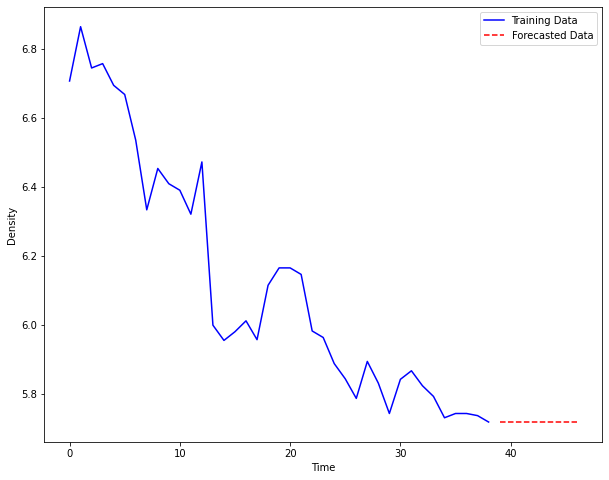

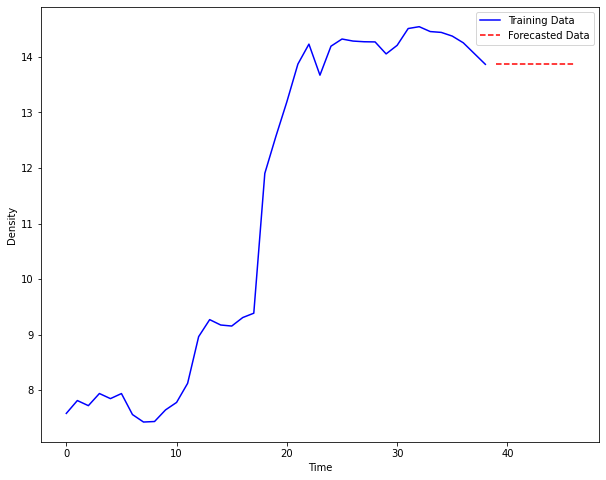

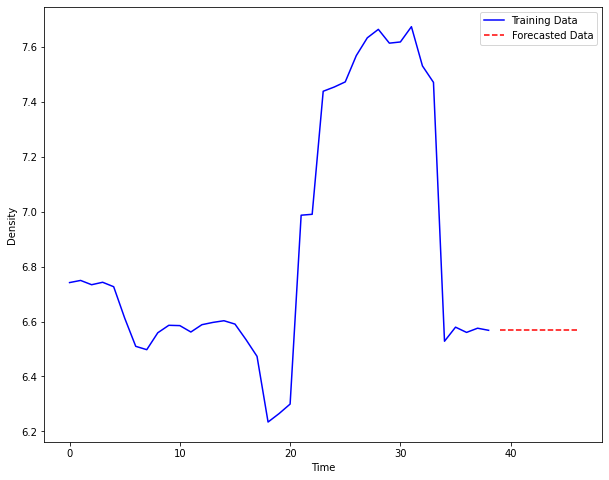

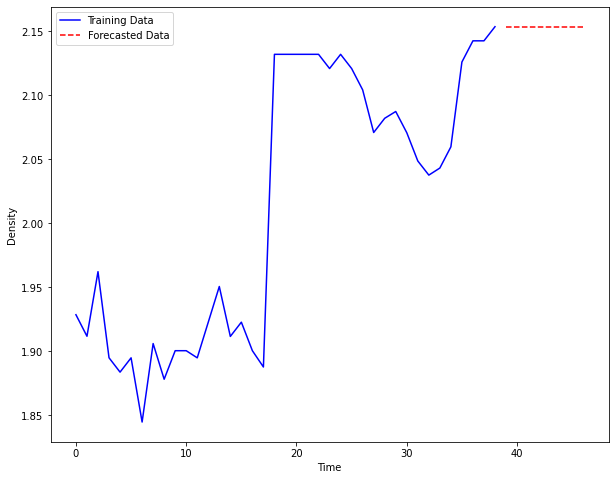

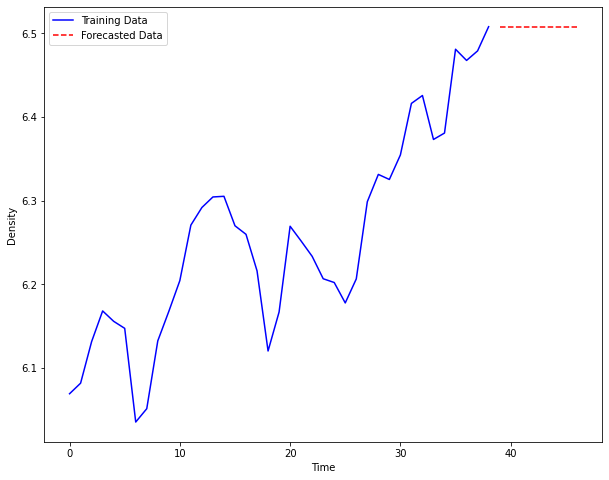

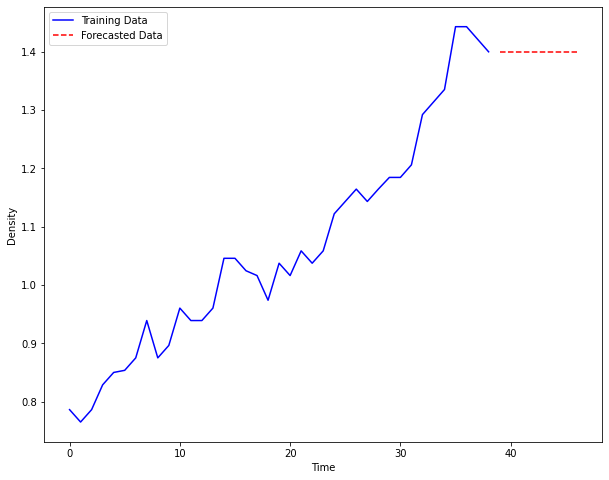

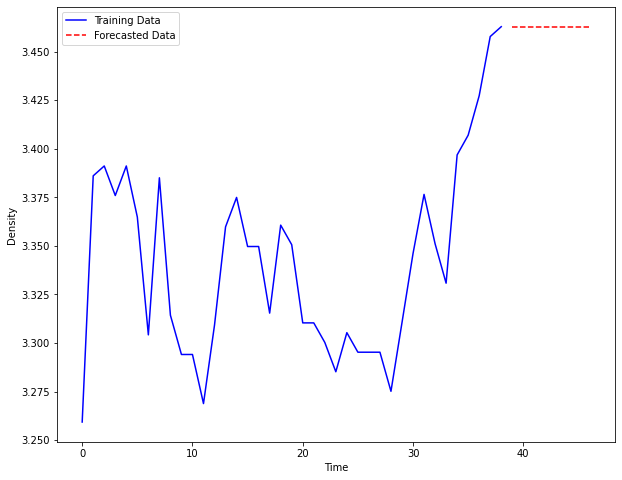

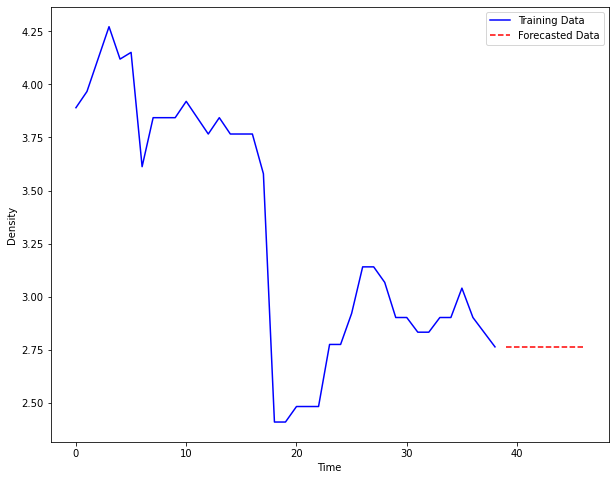

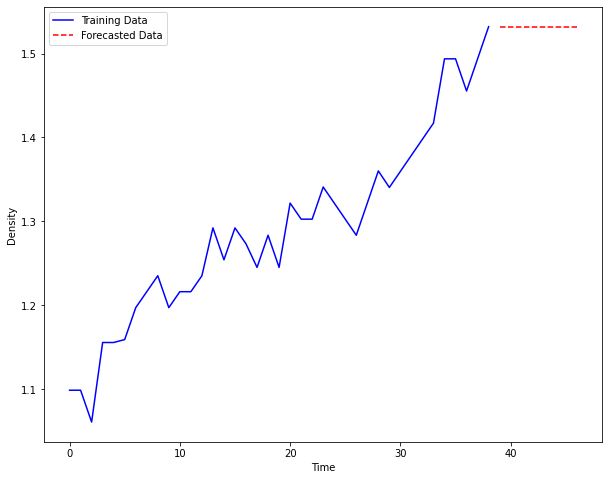

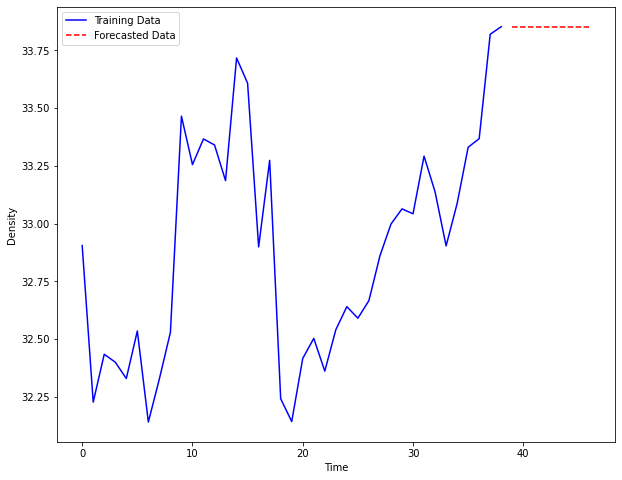

In [61]:
for random_cfips in np.random.choice(cfips_model_train.index.get_level_values('cfips'), size=10):
    
    random_train = cfips_model_train.loc[random_cfips, 'microbusiness_density']
    random_forecast = cfips_model_test.loc[random_cfips, 'microbusiness_density']
    
    # Indices for time series
    train_index = np.arange(len(random_train))
    forecast_index = np.arange(len(random_train), len(random_train) + len(random_forecast))

    fig, ax = plt.subplots(figsize=(10, 8))

    # Plot the training data with a solid blue line
    ax.plot(train_index, random_train, color='blue', linestyle='solid', label='Training Data')

    # Plot the forecasted data with a dashed red line
    ax.plot(forecast_index, random_forecast, color='red', linestyle='dashed', label='Forecasted Data')

    # Set the axis labels and legend
    ax.set_xlabel('Time')
    ax.set_ylabel('Density')
    ax.legend()

    # Show the plot
    plt.show();

In [62]:
# Instantiate empty container for forecast values
cfips_model_forecast = pd.DataFrame({'row_id': test['row_id'],'microbusiness_density': 0})

for i in range(len(cfips_model_forecast['row_id'])):
    index = cfips_model_test.row_id.tolist().index(cfips_model_forecast.iloc[i, 0]) # Match indices in 'cfips_model_test' with indices in 'cfips_model_forecast' using 'row_id'
    cfips_model_forecast.iloc[i, 1] = cfips_model_test.iloc[index, 1]

# Write to disk
cfips_model_forecast.to_csv(path_gdrive + 'output/cfips_model_forecast.csv', index=False) 
cfips_model_forecast

,row_id,microbusiness_density
0,1001_2022-11-01,3.46
1,1003_2022-11-01,8.36
2,1005_2022-11-01,1.23
3,1007_2022-11-01,1.29
4,1009_2022-11-01,1.83
...,...,...
25075,56037_2023-06-01,2.82
25076,56039_2023-06-01,26.27
25077,56041_2023-06-01,4.01
25078,56043_2023-06-01,3.13


### Evaluation Metric

The SMAPE for the CFIPS model is 4.3792, which is a huge performance boost over the baseline.